# 生成验证码

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


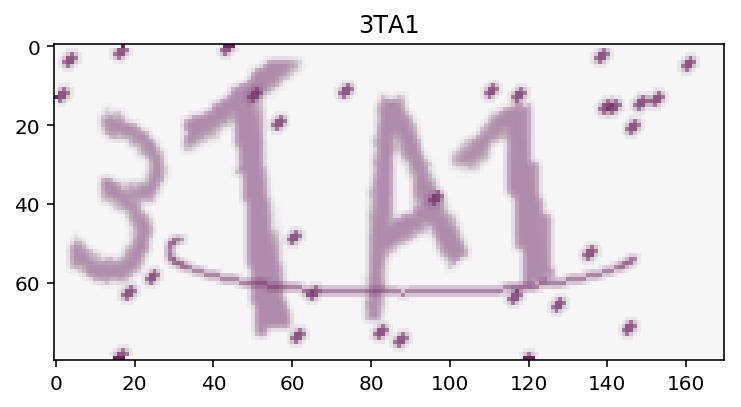

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

# 生成器

In [2]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

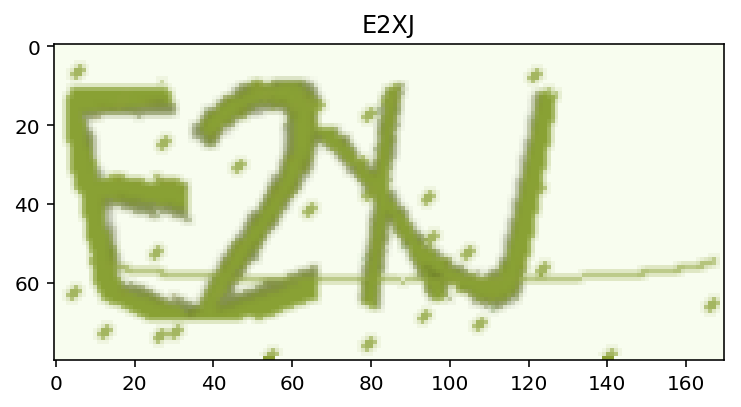

In [3]:
def decode(y, index=0):
    y = np.argmax(np.array(y), axis=2)[:, index]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

# 搭建模型

In [4]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, 3, activation='relu')(x)
    x = Convolution2D(32*2**i, 3, activation='relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs=input_tensor, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

Using TensorFlow backend.


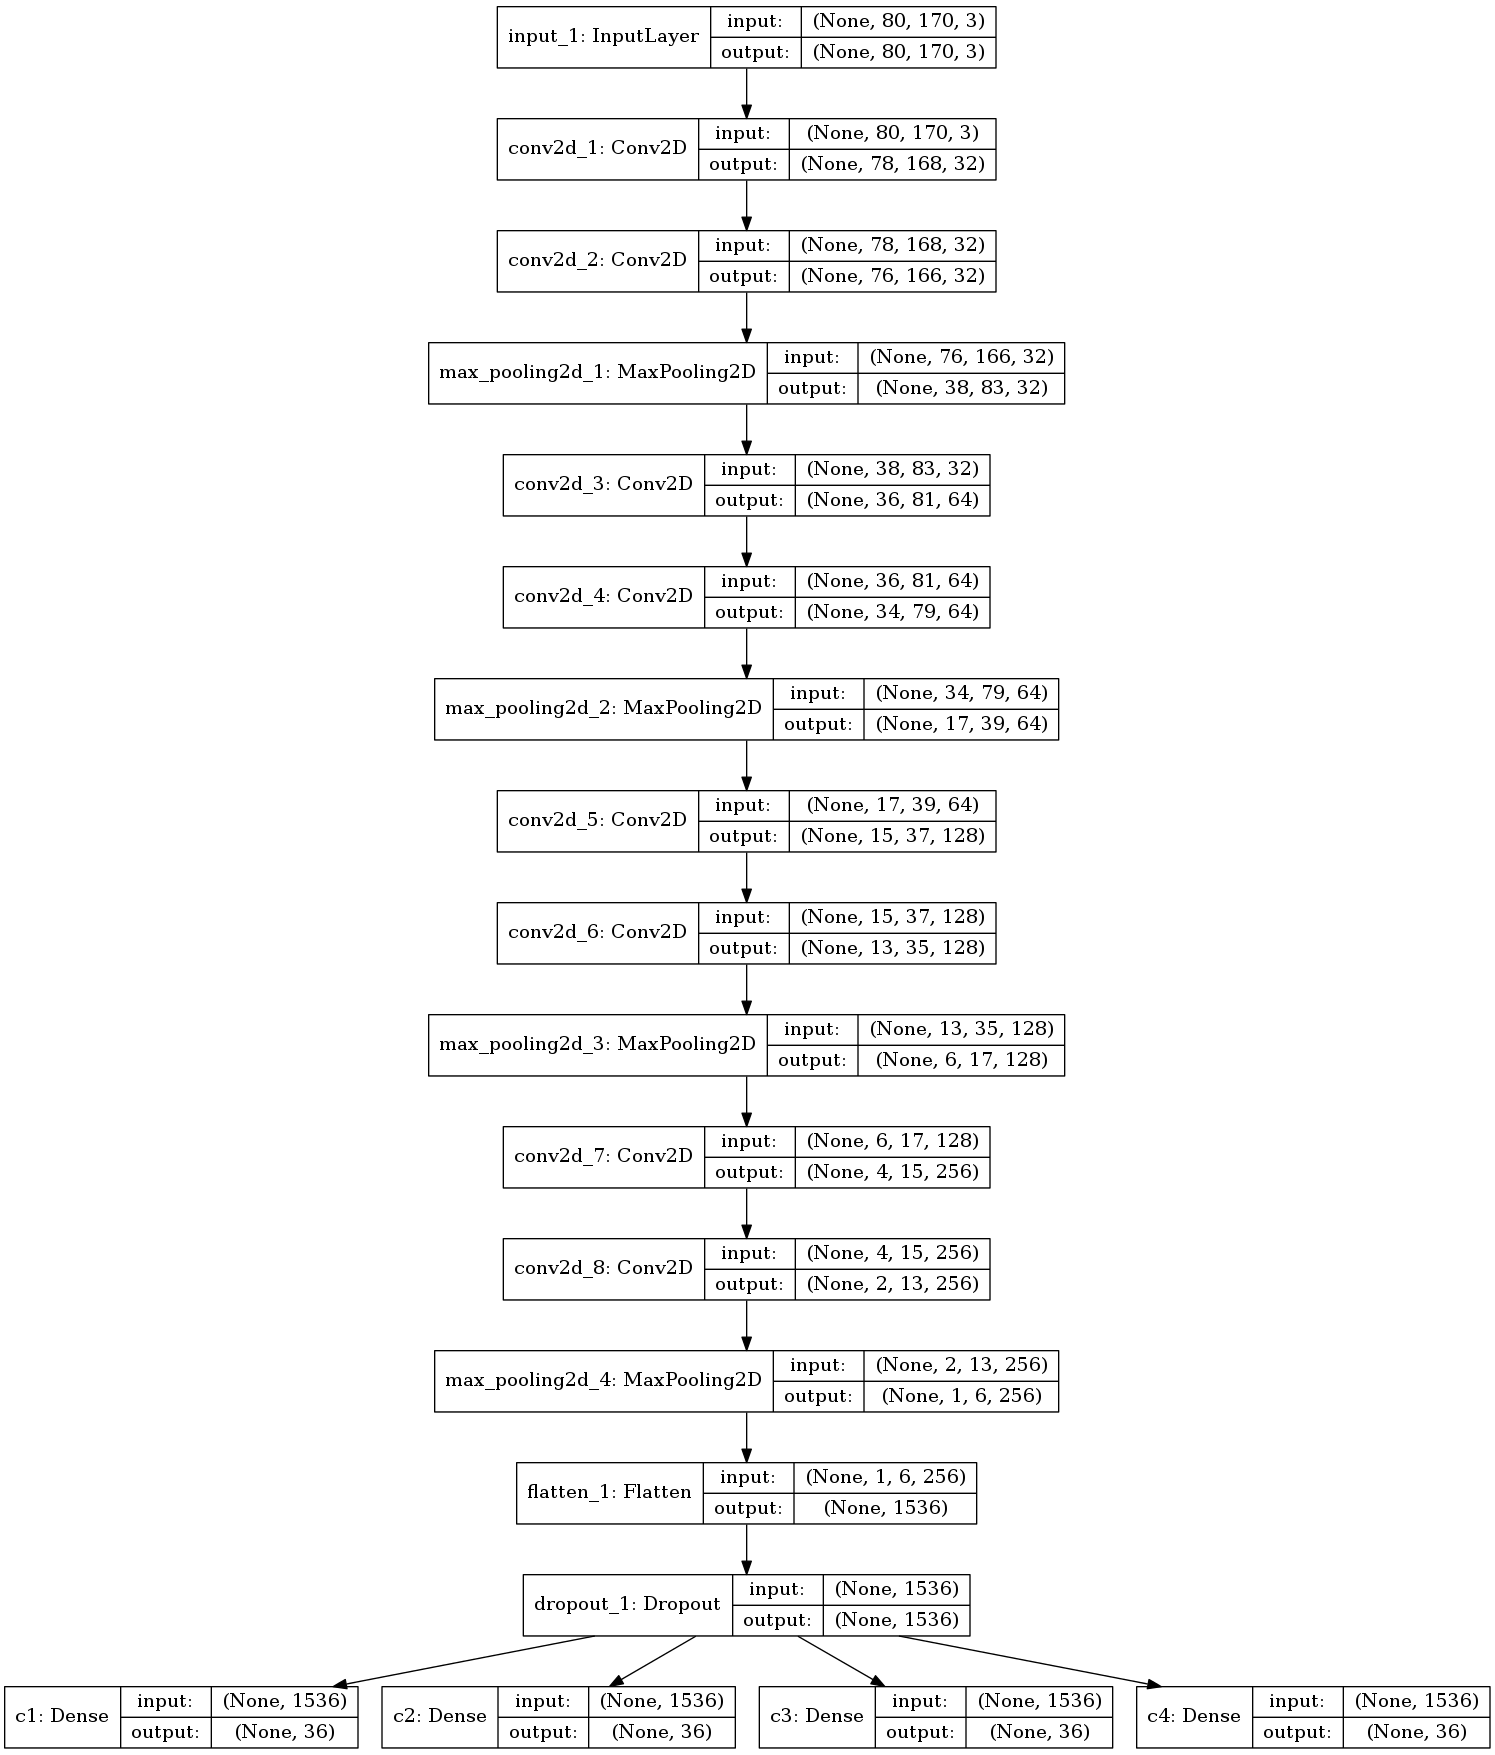

In [5]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 训练模型

In [6]:
h = model.fit_generator(gen(128), steps_per_epoch=400, epochs=20, 
                        workers=4, pickle_safe=True, 
                        validation_data=gen(128), validation_steps=10)

Epoch 1/20
400/400 [==============================] - 53s - loss: 12.5003 - c1_loss: 3.2964 - c2_loss: 2.9964 - c3_loss: 3.0900 - c4_loss: 3.1176 - c1_acc: 0.1089 - c2_acc: 0.1725 - c3_acc: 0.1517 - c4_acc: 0.1500 - val_loss: 6.1443 - val_c1_loss: 1.7571 - val_c2_loss: 1.2386 - val_c3_loss: 1.4987 - val_c4_loss: 1.6499 - val_c1_acc: 0.4531 - val_c2_acc: 0.6094 - val_c3_acc: 0.5500 - val_c4_acc: 0.4828
Epoch 2/20
400/400 [==============================] - 51s - loss: 3.5731 - c1_loss: 0.9599 - c2_loss: 0.6798 - c3_loss: 0.9118 - c4_loss: 1.0216 - c1_acc: 0.6952 - c2_acc: 0.7861 - c3_acc: 0.7334 - c4_acc: 0.7081 - val_loss: 1.2562 - val_c1_loss: 0.2571 - val_c2_loss: 0.2185 - val_c3_loss: 0.3803 - val_c4_loss: 0.4003 - val_c1_acc: 0.9320 - val_c2_acc: 0.9234 - val_c3_acc: 0.8883 - val_c4_acc: 0.8953
Epoch 3/20
400/400 [==============================] - 51s - loss: 1.3366 - c1_loss: 0.2979 - c2_loss: 0.2272 - c3_loss: 0.3720 - c4_loss: 0.4394 - c1_acc: 0.9094 - c2_acc: 0.9324 - c3_acc: 0.

(0.9, 1)

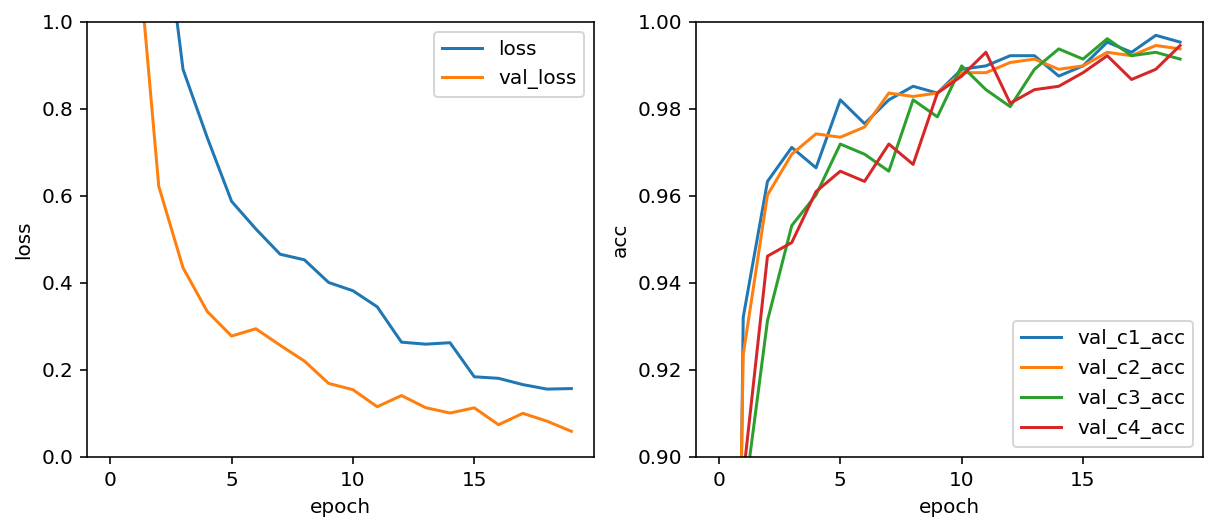

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
for i in range(4):
    plt.plot(h.history['val_c%d_acc' % (i+1)])
plt.legend(['val_c%d_acc' % (i+1) for i in range(4)])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.ylim(0.9, 1)

# 计算模型准确率

In [8]:
from tqdm import tqdm

def evaluate(batch_size=128, steps=20):
    batch_acc = 0
    generator = gen(batch_size)
    for i in tqdm(range(steps)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=-1)
        y_true = np.argmax(y, axis=-1)
        batch_acc += np.equal(y_true, y_pred).all(axis=0).mean()
    return batch_acc / steps

In [9]:
evaluate()

100%|██████████| 20/20 [00:08<00:00,  2.43it/s]


0.97499999999999998

## 测试模型

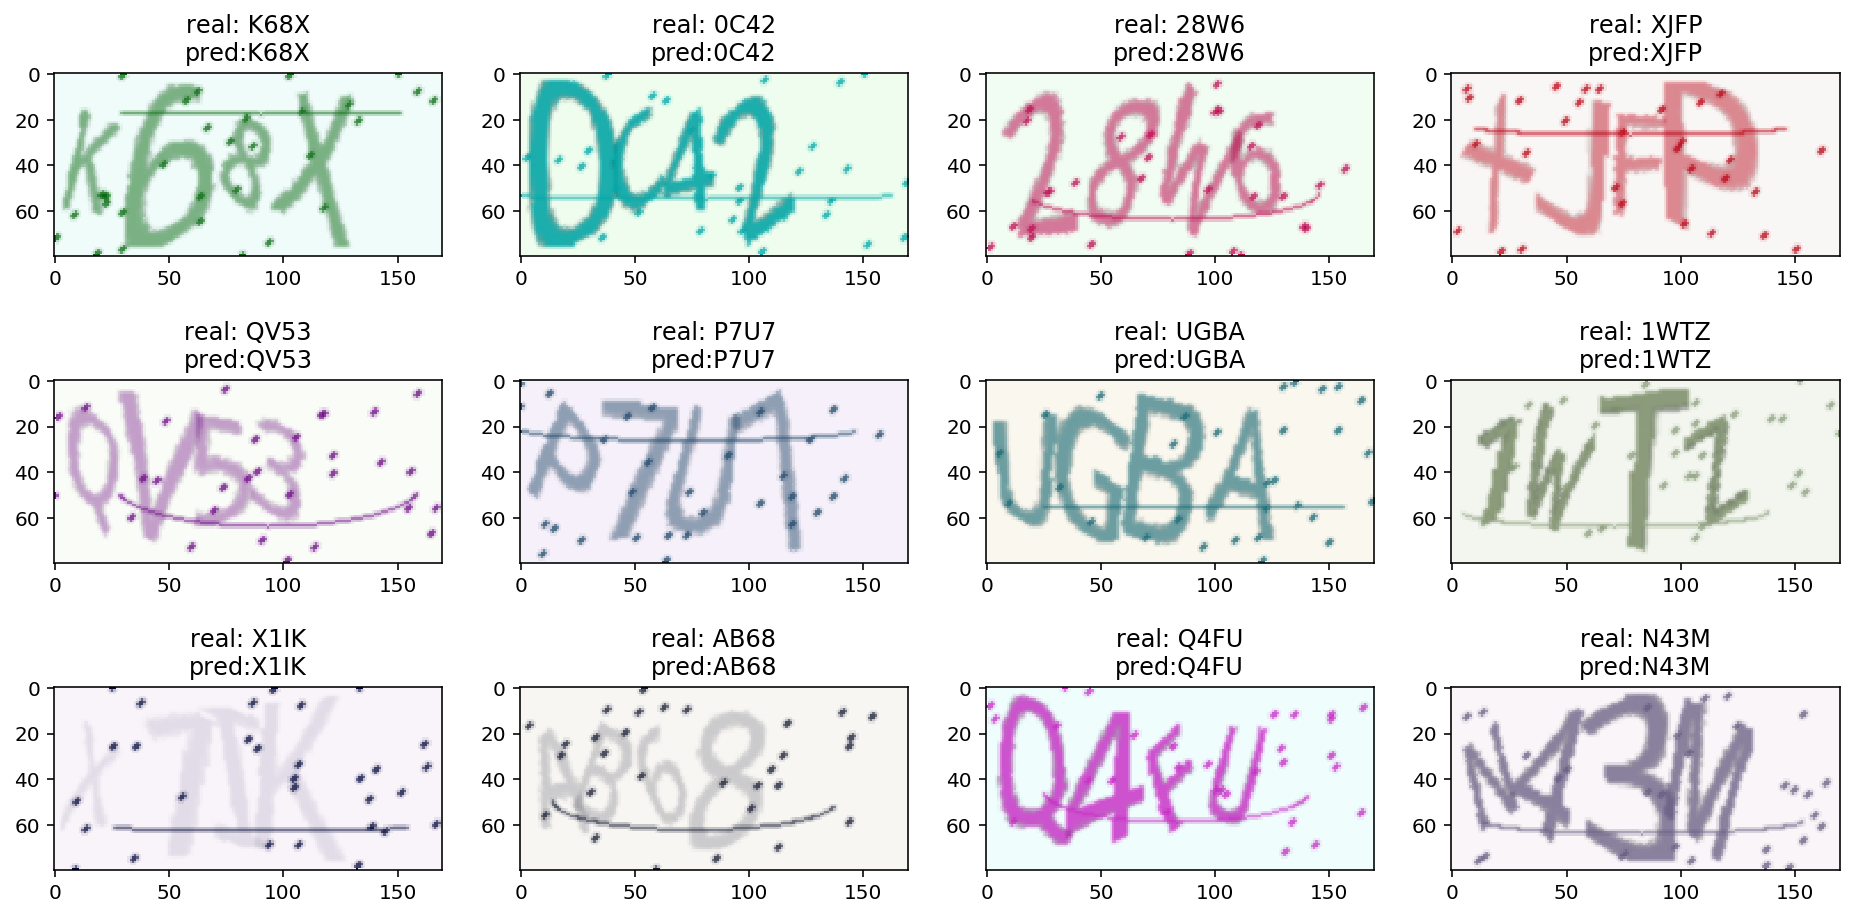

In [10]:
X, y = next(gen(12))
y_pred = model.predict(X)

plt.figure(figsize=(16, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.title('real: %s\npred:%s'%(decode(y, i), decode(y_pred, i)))
    plt.imshow(X[i])

In [11]:
model.save('model.h5')